calculate  the scattering phase shifts and binding energy for N Omega (5S2) system
using fitted parameters

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import pickle
import scipy.optimize
import scipy.constants

In [4]:
# use uncertainties library (pip install uncertaintes)
from uncertainties import ufloat

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
hbarc = (scipy.constants.hbar * scipy.constants.speed_of_light
         / scipy.constants.mega / scipy.constants.electron_volt / scipy.constants.femto)

ainv = 2.333e3
lat_unit = hbarc/ainv
momega = 1.71153e3/ainv
mn = 0.95469e3/ainv
mpi = 0.146e3/ainv
L = 96
bin_num = 20 # number of the jackknife sample
spin = 2

In [7]:
m_red = mn * momega/(mn + momega)

In [8]:
print(f'N = {mn*ainv:3.2f} [MeV], Omega = {momega*ainv:3.2f} [MeV]')
print(f'redueced mass = {m_red*ainv:3.2f} [MeV]')

N = 954.69 [MeV], Omega = 1711.53 [MeV]
redueced mass = 612.85 [MeV]


In [9]:
V_fit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] *  (
                1 - np.exp(-p[3]*x**2)) * (np.exp(-mpi*x)/(x+1.0e-5))**2

load fit paremeter (Run "N Omega potential and fit.ipynb" before using this notebook)

In [10]:
with open('pkls/FF_yukawa2_fit_result.pkl', 'rb') as fin:
    FF_yukawa2_prm_av, FF_yukawa2_prm_jk = pickle.load(fin)

check parameter

Text(0.5,1.02,'$N\\Omega$($^{5}$S$_{2}$), $t/a = 12$')

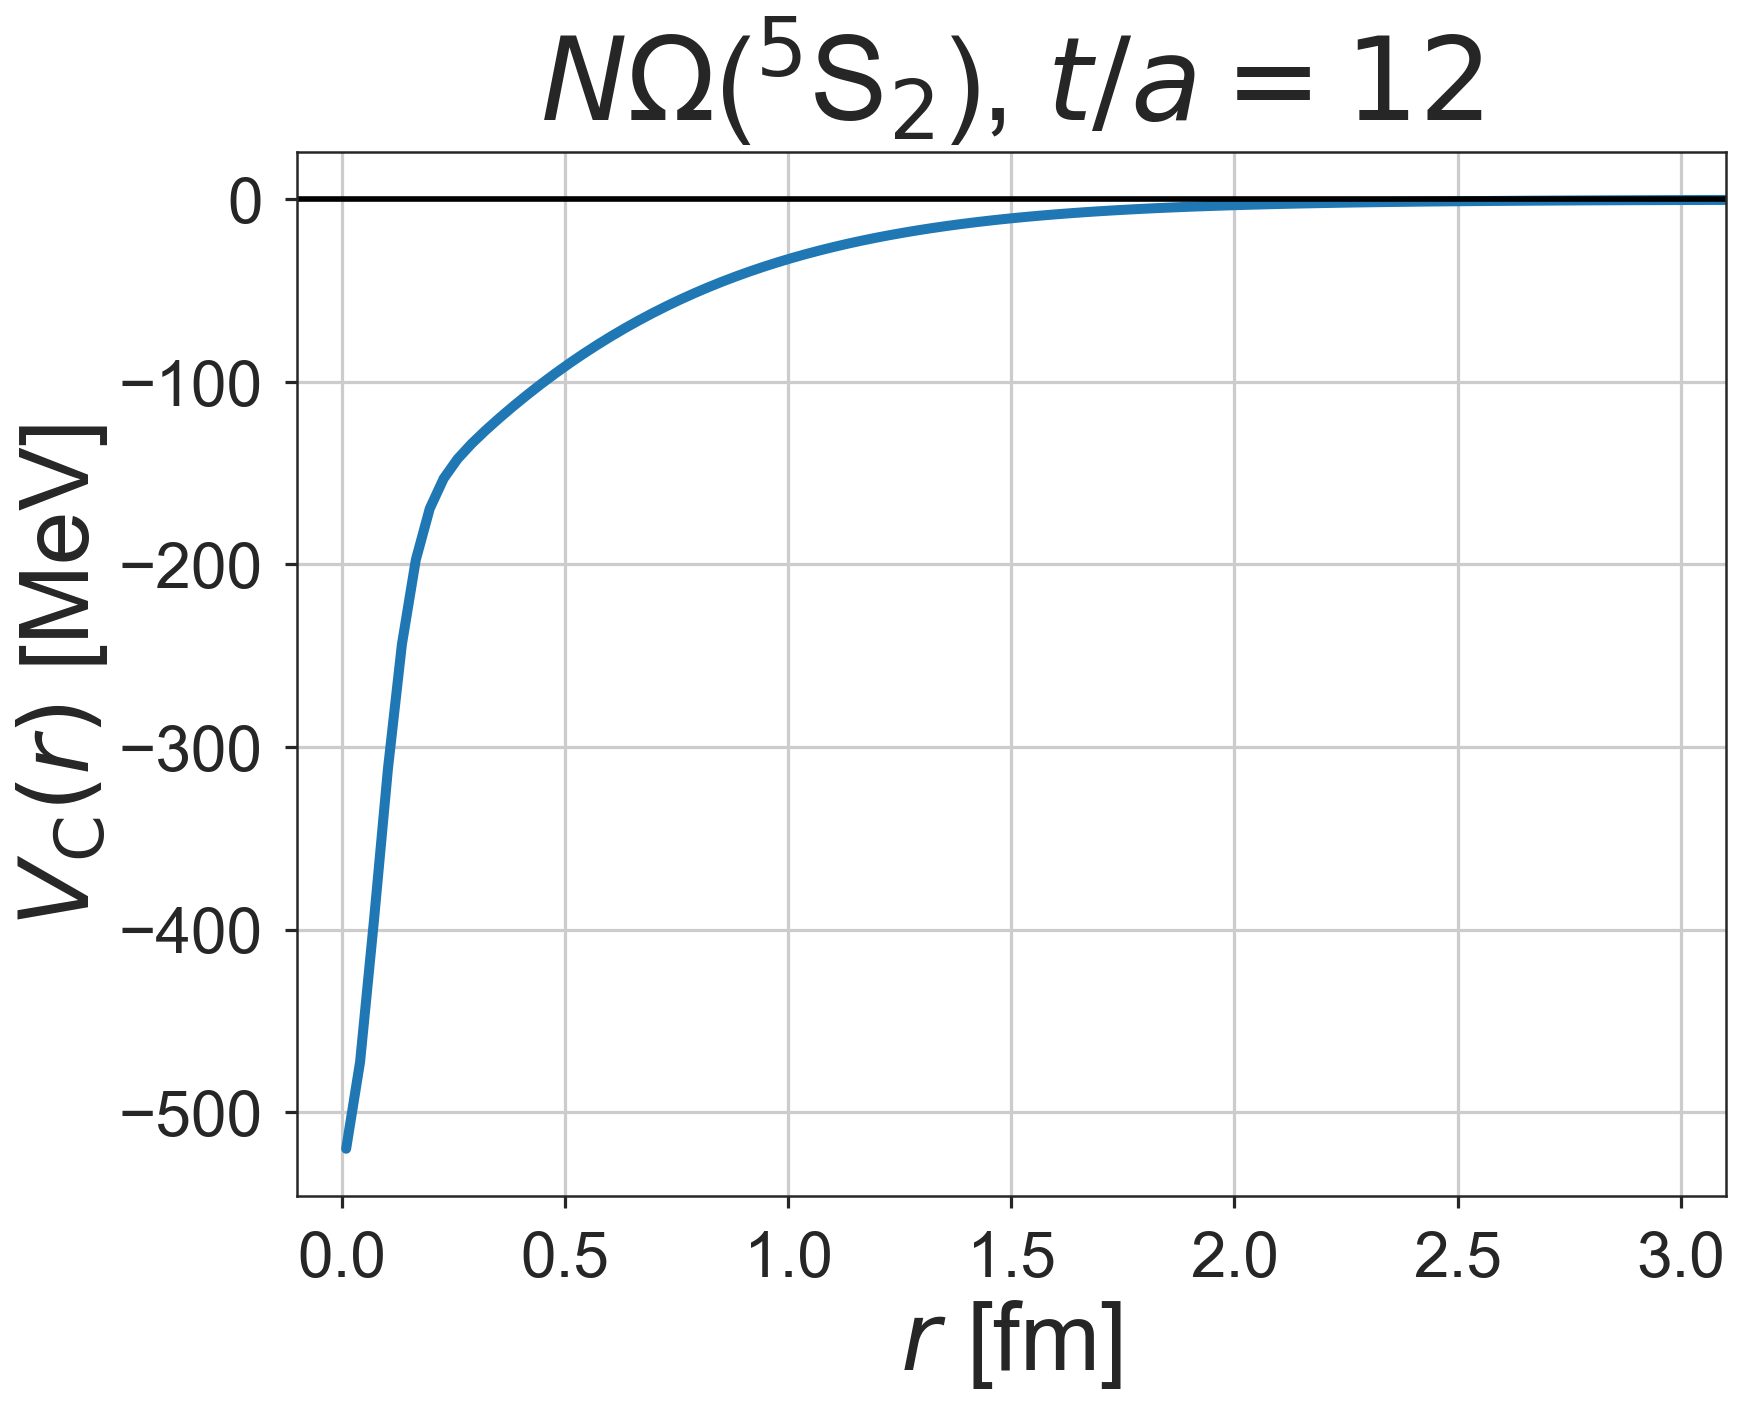

In [11]:
it = 12
xls = np.linspace(0.01, 3.10, 100)/lat_unit
fig, ax = plt.subplots()
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv, lw=5)
ax.axhline(0, color='black')
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_\mathrm{C}(r)$ [MeV]', size=48)
ax.set_xlim(-0.10, 3.10)
ax.set_title(rf'$N\Omega$($^{{{spin*2+1:d}}}$S$_{{{spin:d}}}$), $t/a = {it:d}$', size=58, y=1.02)



Schroedinger eq.

In [12]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-5, r_max = 10/lat_unit, r_diff = 1.0e-3):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-3):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$', size=48)
        ax.set_ylabel(r'$\delta$ [rad.]', size=48)
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-3):
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))       

In [13]:
def eval_deltas(k2s, pot):
    scheq = Schroedinger_Eq(pot, m_red)
    deltas =  []
    for k2 in k2s:
        deltas.append(scheq.calc_phase_shift(k2))
        
    return np.array(deltas)

In [14]:
# calculate the scattering phase shifts
deltas_ff_yukawa2_jk = {}
deltas_ff_yukawa2_av = {}
k2s = np.linspace(1.0e-5, 1.25, 100)*mpi**2
k2s_ff_yukawa2 = k2s
for it in tqdm([11, 12, 13, 14]):
    pot = lambda x: V_fit(FF_yukawa2_prm_av[it], x)
    deltas_ff_yukawa2_av[it] = eval_deltas(k2s, pot)
    _delta = []
    for ibin in range(bin_num):
        pot = lambda x: V_fit(FF_yukawa2_prm_jk[it][ibin,:], x)
        _delta.append(eval_deltas(k2s, pot))
    deltas_ff_yukawa2_jk[it] = np.array(_delta)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [15]:
mkdir -p ../figs/phase_shifts

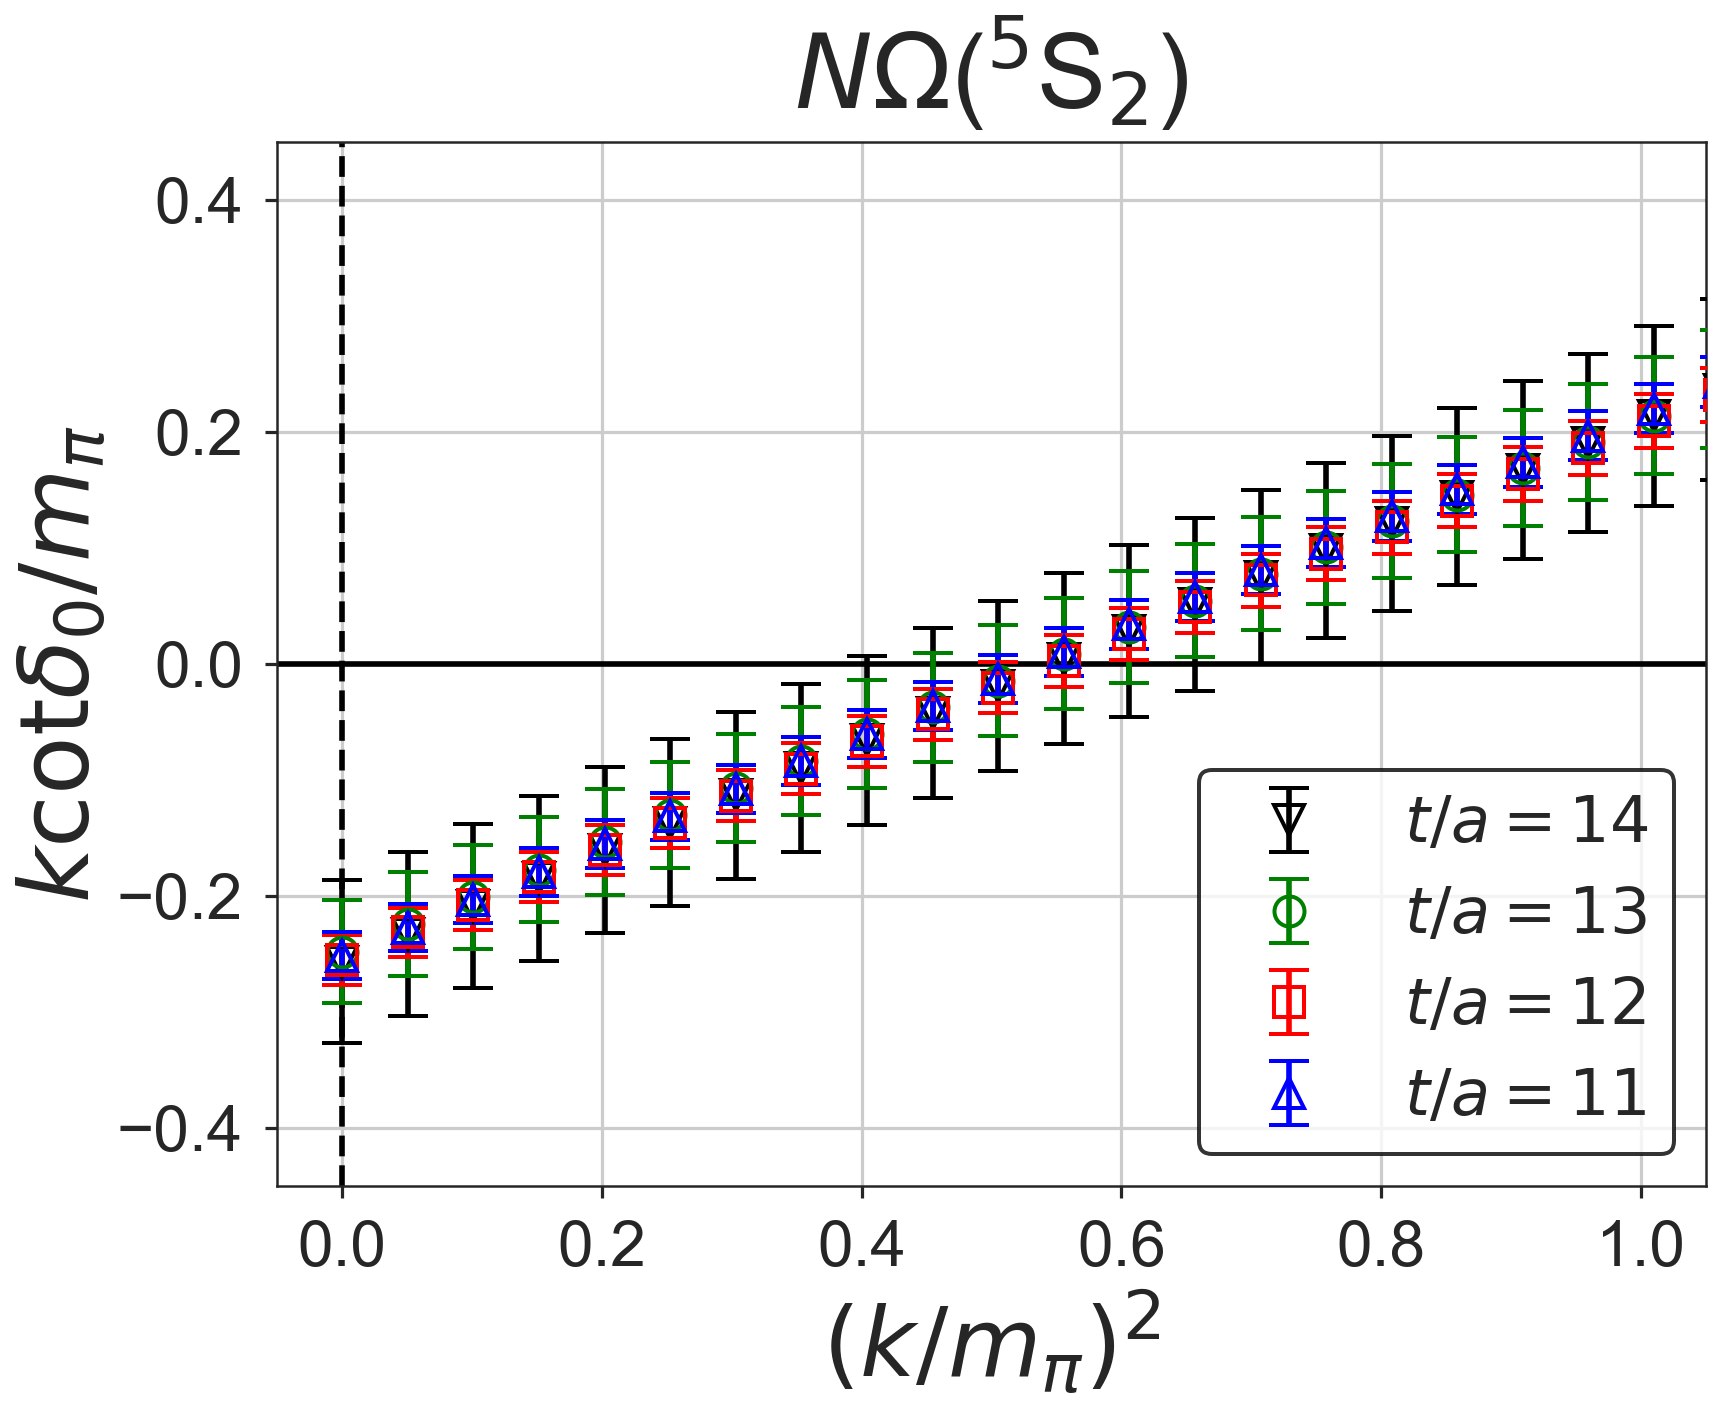

In [16]:
fig, ax = plt.subplots()
for it, col, fmt, ith in zip([14, 13, 12, 11], ['black', 'green', 'red', 'blue'], ['v', 'o', 's', '^'], [0,1,2,3]):
    ys_jk = np.sqrt(k2s)/np.tan(deltas_ff_yukawa2_jk[it])/mpi
    ax.errorbar(k2s[::4]/mpi**2, ys_jk.mean(axis=0)[::4],
                ys_jk.std(axis=0)[::4] * np.sqrt(ys_jk.shape[0] - 1),
                fmt=fmt, color=col, ms=15, mfc='none', mew=2.0, mec=col, capsize=10, capthick=2,
                zorder=3, label=r'$t/a = {}$'.format(it))
ax.set_xlim(-0.05, 1.05)
ax.axhline(0, color='black')
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel(r'$(k/m_\pi)^2$', size=48)
ax.set_ylabel(r'$k\cot\delta_0/m_\pi$', size=48)
ax.set_title(r'$N\Omega$($^5$S$_2$)', size=52, y=1.02)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_ylim(-0.45, 0.45)
fig.savefig('../figs/phase_shifts/kcot_delta_nomega_t11_14.pdf', bbox_inches='tight')

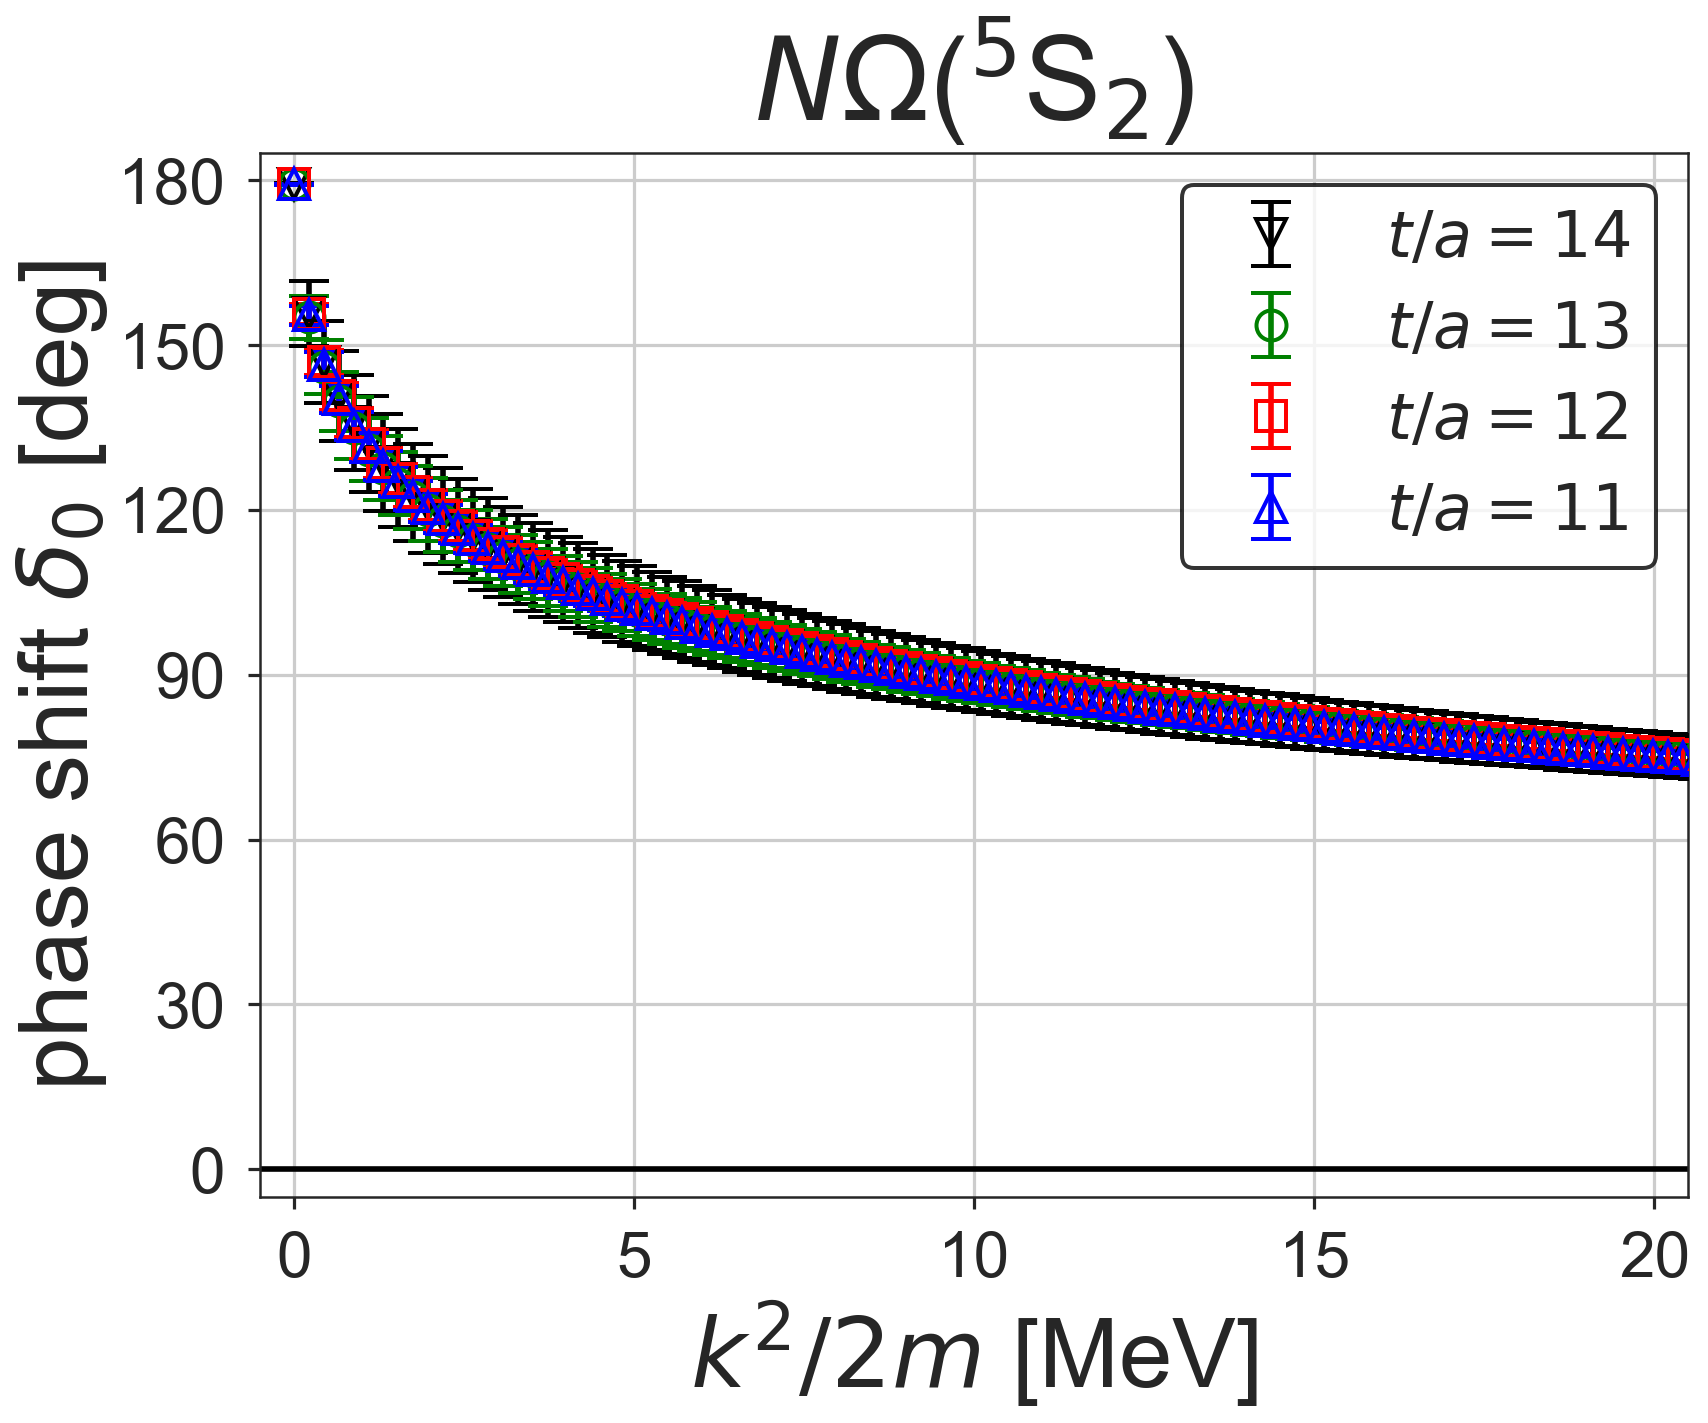

In [17]:
fig, ax = plt.subplots()
for it, col, fmt in zip([14, 13, 12, 11], ['black', 'green', 'red', 'blue'], ['v', 'o', 's', '^']):
    ys_jk = deltas_ff_yukawa2_jk[it]*180/np.pi
    mask = ys_jk < 0
    ys_jk[mask] += 180
    ax.errorbar(k2s[:]/(2.0*m_red)*ainv, ys_jk.mean(axis=0)[:],
                ys_jk.std(axis=0)[:] * np.sqrt(ys_jk.shape[0] - 1),
                fmt=fmt, color=col, ms=15, mfc='none', mew=2.0, mec=col, capsize=10, capthick=2,
                zorder=3, label=r'$t/a = {}$'.format(it))
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(-5, 185)
ax.set_yticks([0,30,60,90,120,150,180])
ax.axhline(0, color='black')
ax.set_xlabel(r'$k^2/2m$ [MeV]', size=48)
ax.set_ylabel(r'phase shift $\delta_0$ [deg]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_title(r'$N\Omega$($^5$S$_2$)', size=58, y=1.02)
fig.savefig('../figs/phase_shifts/delta_nomega_t11_14.pdf', bbox_inches='tight')

# effective range expansion

\begin{equation}
k\cot\delta = - \frac{1}{a_0} + \frac{1}{2}r_\mathrm{eff} k^2
\end{equation}

In [18]:
ere_fit_ff_yukawa2 = {}
for it in [11, 12, 13, 14]:
    ere = lambda p, x: p[0] + 0.5*p[1]*x
    errf = lambda p, y, x, err: (ere(p,x)-y)/err

    ys_jk = np.sqrt(k2s_ff_yukawa2)/np.tan(deltas_ff_yukawa2_jk[it])/mpi
    xs = k2s_ff_yukawa2/mpi**2
    ys = ys_jk.mean(axis=0)
    yerrs = ys_jk.std(axis=0)*np.sqrt(ys_jk.shape[0] - 1)
    ere_fit_prm = []
    for ibin in range(bin_num):
        mask = xs < 0.4
        pfit = scipy.optimize.leastsq(errf, [-5, 0.1],
                                 args=(ys_jk[ibin,:][mask], xs[mask], yerrs[mask]), full_output=True)
        ere_fit_prm.append(pfit[0])
        
    ere_fit_ff_yukawa2[it] = np.array(ere_fit_prm)

check ERE paramters

t  a0     reff
11 5.376 0.437 1.281 0.011
12 5.296 0.443 1.262 0.012
13 5.457 0.962 1.256 0.023
14 5.286 1.426 1.278 0.046


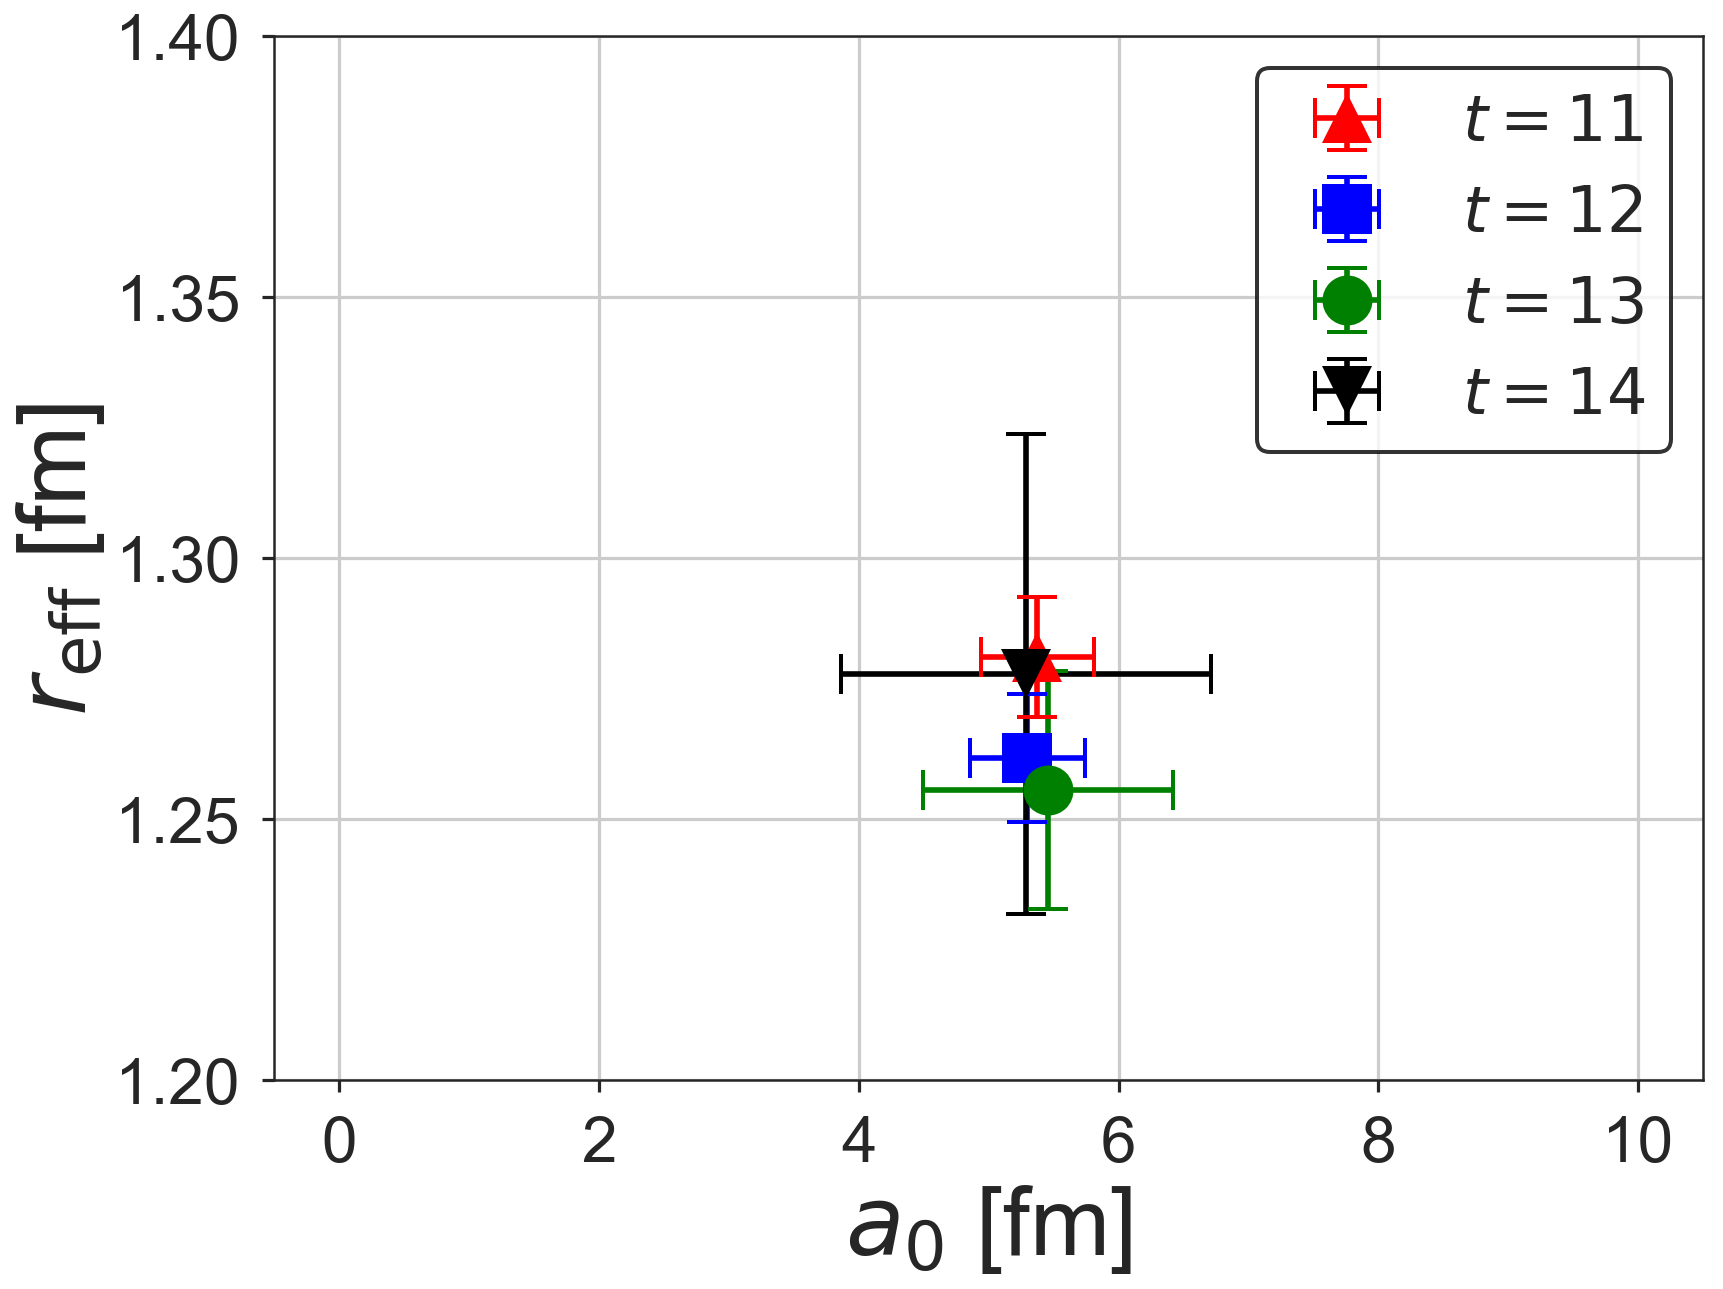

In [19]:
fig, ax = plt.subplots()

print('t  a0     reff')
for it, col, fmt in zip([11, 12, 13, 14], ['red', 'blue', 'green', 'black'], ['^', 's', 'o', 'v']):
    xs = -1.0/(ere_fit_ff_yukawa2[it][:,0]*mpi)*lat_unit
    ys = ere_fit_ff_yukawa2[it][:,1]/mpi*lat_unit
    ax.errorbar(xs.mean(), ys.mean(),
               ys.std()*np.sqrt(bin_num-1), xerr=xs.std()*np.sqrt(bin_num-1),
               fmt=fmt, color=col, label=r'$t = {}$'.format(it),
                ms=25,  capthick=2, capsize=10)
    print('{} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(it, 
            xs.mean(), xs.std()*np.sqrt(bin_num-1),
    ys.mean(), ys.std()*np.sqrt(bin_num-1)))
    
ax.set_xlabel(r'$a_0$ [fm]', size=48)
ax.set_ylabel(r'$r_\mathrm{eff}$ [fm]', size=48)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(1.2, 1.4)
ax.set_yticks([1.2, 1.25, 1.3, 1.35, 1.4])
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)


summarize ERE parameter

In [20]:
def plot_ere_prm_nomega_5s2(ax):
    xs = -1.0/(ere_fit_ff_yukawa2[12][:,0]*mpi)*lat_unit
    ys = ere_fit_ff_yukawa2[12][:,1]/mpi*lat_unit

    xs_max = np.max([(-1.0/(ere_fit_ff_yukawa2[it][:,0]*mpi)*lat_unit).mean() for it in [11, 12, 13, 14]])
    xs_min = np.min([(-1.0/(ere_fit_ff_yukawa2[it][:,0]*mpi)*lat_unit).mean() for it in [11, 12, 13, 14]])

    ys_max = np.max([(ere_fit_ff_yukawa2[it][:,1]/mpi*lat_unit).mean() for it in [11, 12, 13, 14]])
    ys_min = np.min([(ere_fit_ff_yukawa2[it][:,1]/mpi*lat_unit).mean() for it in [11, 12, 13, 14]])

    yerrs = ys.std()*np.sqrt(bin_num-1)
    xerrs = xs.std()*np.sqrt(bin_num-1)

    print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f})'.format(xs.mean(), xerrs, (xs_max-xs.mean()), (xs_min - xs.mean())))
    print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f})'.format(ys.mean(), yerrs, (ys_max-ys.mean()), (ys_min - ys.mean())))
    xvals = xs.mean(), xerrs, (xs_max-xs.mean()), (xs_min - xs.mean())
    yvals = ys.mean(), yerrs, (ys_max-ys.mean()), (ys_min - ys.mean())
    result = r'$a_0 = {:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ fm'.format(xvals[0], xvals[1], xvals[2], xvals[3]) \
          + '\n' + r'$r_\mathrm{{eff}} = {:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ fm'.format(yvals[0], yvals[1], yvals[2], yvals[3])
    
    # outer errorbar (with systematic)
    eb = ax.errorbar(xs.mean(), ys.mean(), [[np.sqrt(yerrs**2 + (ys_min-ys.mean())**2)],
                                       [np.sqrt(yerrs**2 + (ys_max-ys.mean())**2)]],
               xerr=[[np.sqrt(xerrs**2 + (xs_min-xs.mean())**2)],
                    [np.sqrt(xerrs**2 + (xs_max-xs.mean())**2)]],
               fmt='o', color='red', ms=25, capthick=2.0, capsize=10,
                    label=result)
    eb[-1][0].set_linestyle('--')
    eb[-1][1].set_linestyle('--')

    ax.errorbar(xs.mean(), ys.mean(), ys.std()*np.sqrt(bin_num-1),
               xerr=xs.std()*np.sqrt(bin_num-1),
               fmt='o', color='red', ms=25, capthick=2.0, capsize=10)


5.30(0.44)(+0.16)(-0.01)
1.26(0.01)(+0.02)(-0.01)


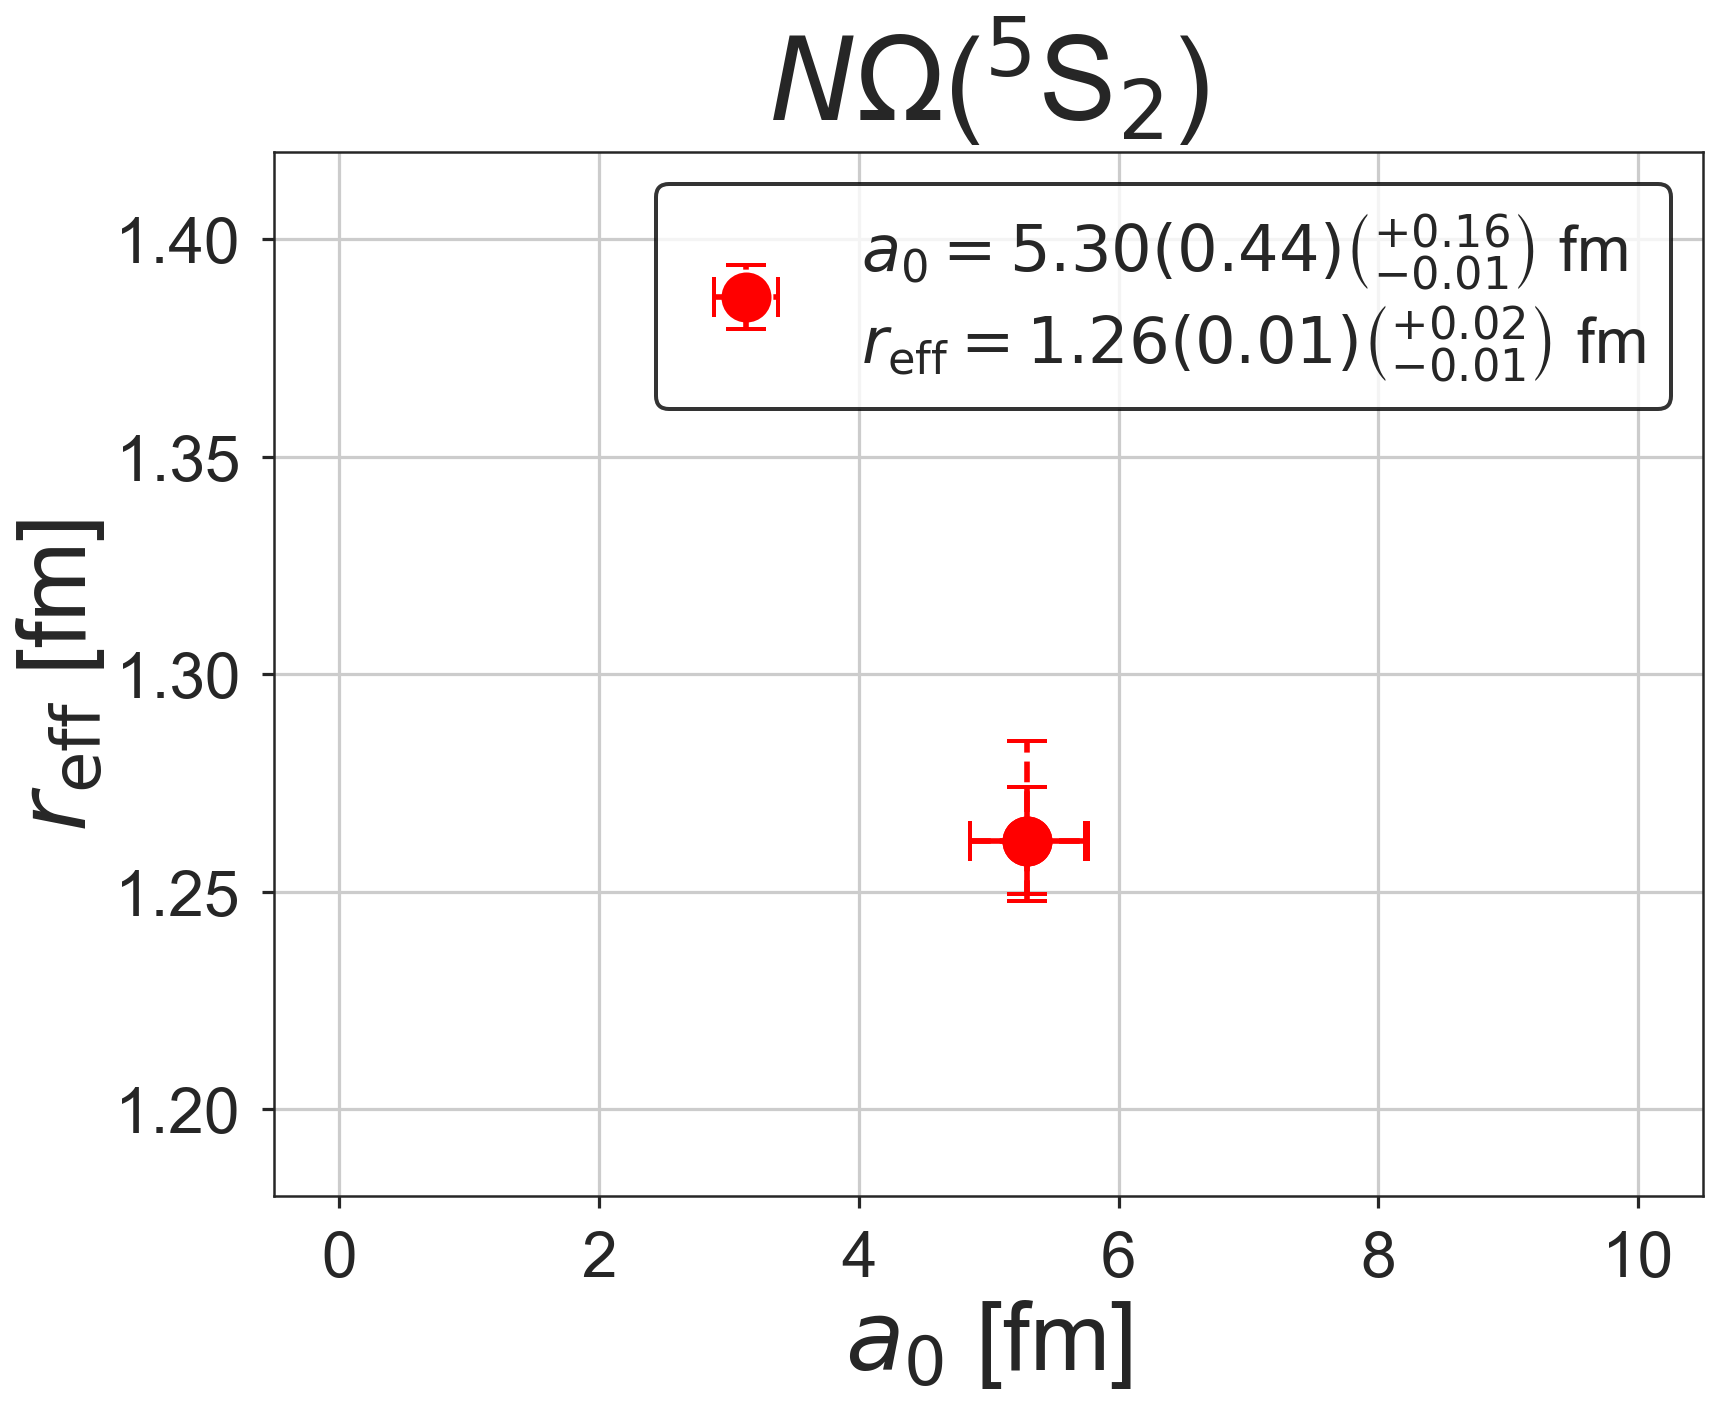

In [21]:
fig, ax = plt.subplots()
plot_ere_prm_nomega_5s2(ax)

ax.set_xlabel(r'$a_0$ [fm]', size=48)
ax.set_ylabel(r'$r_\mathrm{eff}$ [fm]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(1.18, 1.42)
ax.set_title(r'$N\Omega$($^5$S$_2$)', size=58, y=1.02)

ax.set_yticks(np.arange(1.2, 1.41, 0.05));

compare other dibarions

In [22]:
omega_ys = [0.216, 0.278, 0.328]
omega_xs = [1.231, 1.272, 1.339]

OmegaOmega reff = 1.27(+0.07)(-0.04) fm
OmegaOmega ratio = 0.28(+0.05)(-0.06)
NOmega reff = 1.26(0.01)(0.02)(-0.01) fm
NOmega ratio = 0.24(0.02)(0.00)(-0.01)
1S0 reff = 1.74 fm, ratio = 0.32
3S1 reff = 2.75 fm, ratio = -0.12


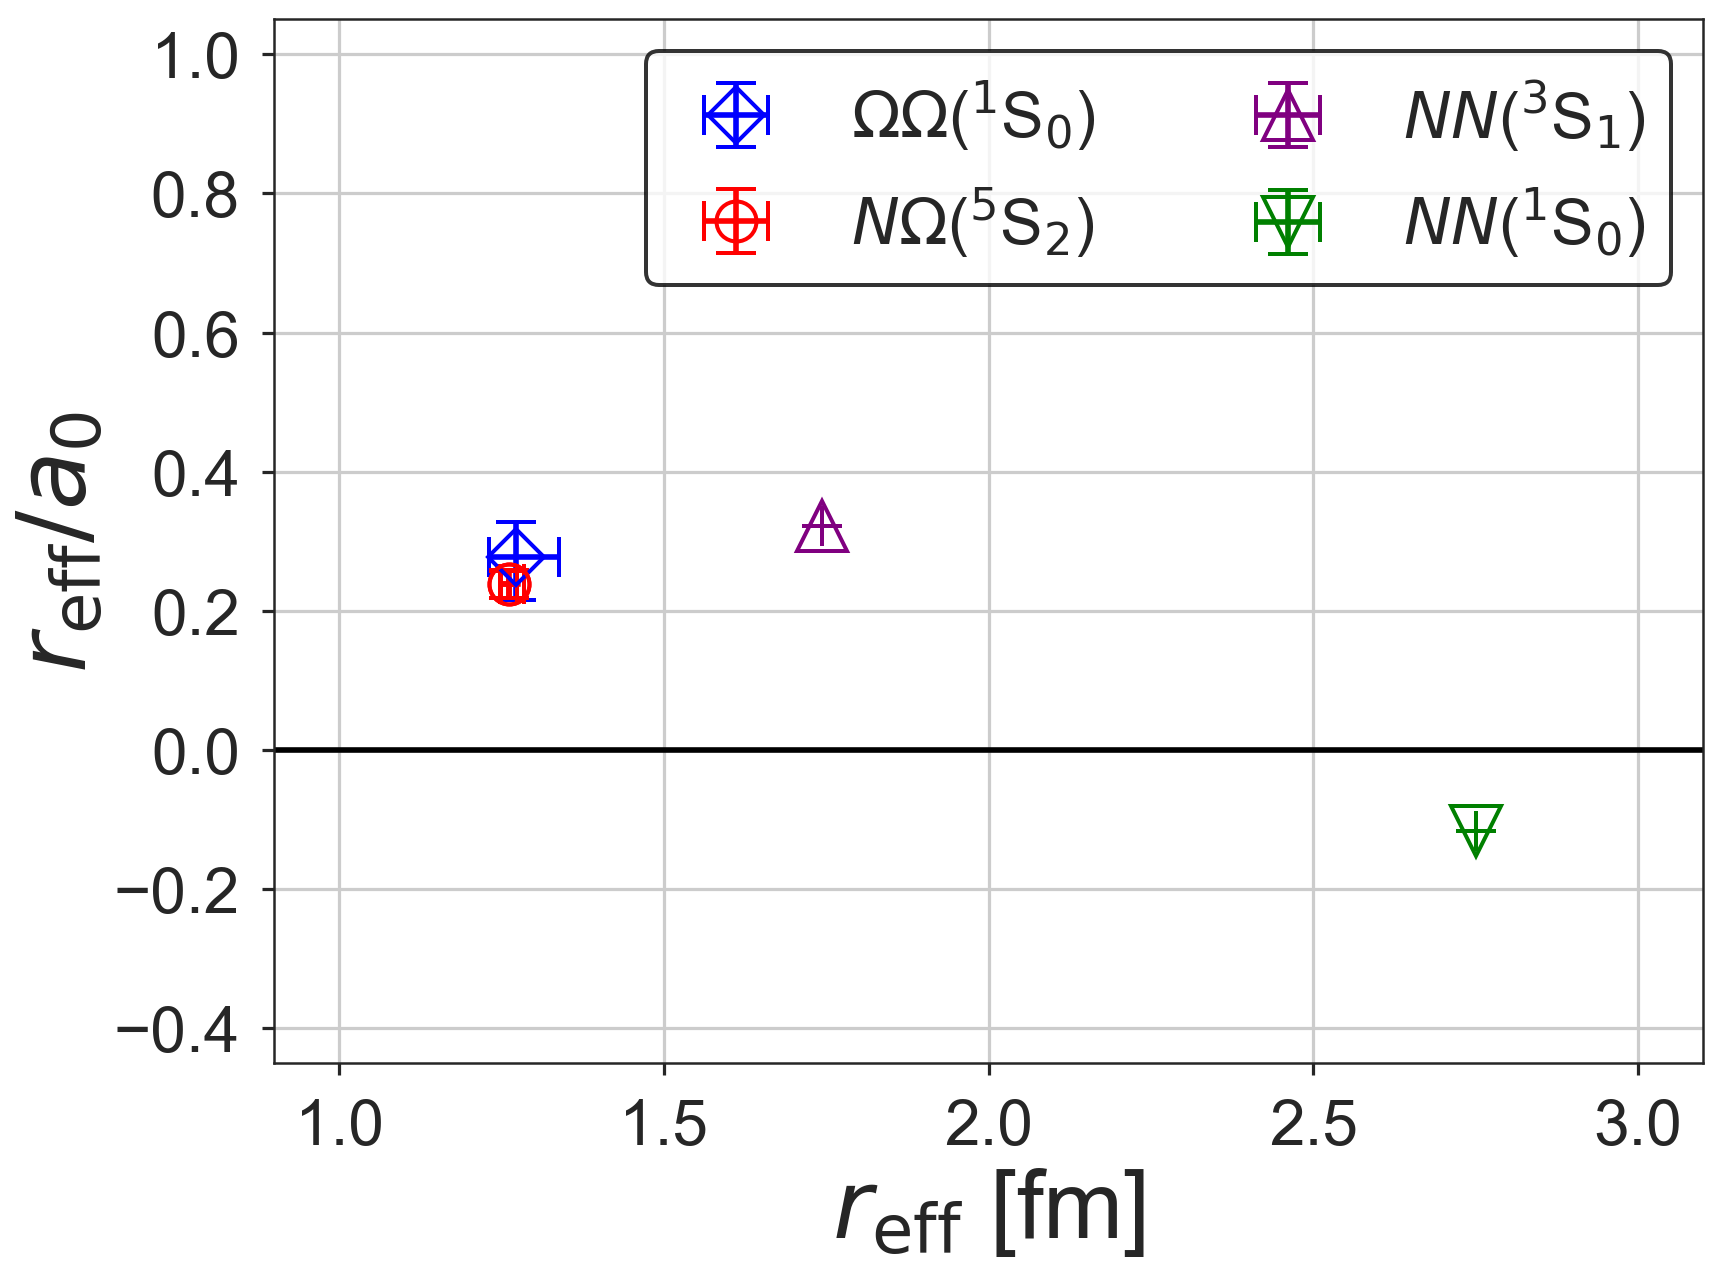

In [23]:
fig, ax = plt.subplots()

ax.errorbar(omega_xs[1], omega_ys[1],
           yerr=[[omega_ys[1]-omega_ys[0]], [-omega_ys[1]+omega_ys[2]]],
           xerr=[[omega_xs[1]-omega_xs[0]], [-omega_xs[1]+omega_xs[2]]],
           ms=20, fmt='D', color='blue', capthick=2.0, capsize=10,
            mfc='none', mew=2.0, mec='blue',
           label=r'$\Omega\Omega$($^1$S$_0$)')

print('OmegaOmega reff = {:3.2f}({:+3.2f})({:+3.2f}) fm'.format(
    omega_xs[1], omega_xs[2] - omega_xs[1], omega_xs[0] - omega_xs[1]))
print('OmegaOmega ratio = {:3.2f}({:+3.2f})({:+3.2f})'.format(
    omega_ys[1], omega_ys[2] - omega_ys[1], omega_ys[0] - omega_ys[1]))

# n omega (5S2)
ys = -ere_fit_ff_yukawa2[12][:,0] * ere_fit_ff_yukawa2[12][:,1]
xs = ere_fit_ff_yukawa2[12][:,1]/mpi*lat_unit

ys_max = (-ere_fit_ff_yukawa2[13][:,0]* ere_fit_ff_yukawa2[13][:,1]).mean()
ys_min = (-ere_fit_ff_yukawa2[11][:,0]* ere_fit_ff_yukawa2[11][:,1]).mean()

xs_max = (ere_fit_ff_yukawa2[11][:,1]/mpi*lat_unit).mean()
xs_min = (ere_fit_ff_yukawa2[13][:,1]/mpi*lat_unit).mean()
yerrs = ys.std()*np.sqrt(bin_num-1)
xerrs = xs.std()*np.sqrt(bin_num-1)

eb = ax.errorbar(xs.mean(), ys.mean(), 
                 [[np.sqrt(yerrs**2 + (ys_min-ys.mean())**2)], [np.sqrt(yerrs**2 + (ys_max-ys.mean())**2)]],
           xerr=[[np.sqrt(xerrs**2 + (xs_min-xs.mean())**2)], [np.sqrt(xerrs**2 + (xs_max-xs.mean())**2)]],
           fmt='o', color='red', ms=20, capthick=2.0, capsize=10, mec='red', mew=2.0, mfc='none')
eb[-1][0].set_linestyle('--')
eb[-1][1].set_linestyle('--')

ax.errorbar(xs.mean(), ys.mean(), ys.std()*np.sqrt(bin_num-1),
           xerr=xs.std()*np.sqrt(bin_num-1),
           fmt='o', color='red', ms=20, capthick=2.0, capsize=10,
           mfc='none', mec='red', mew=2.0, label=r'$N\Omega$($^5$S$_2$)')

print('NOmega reff = {:3.2f}({:3.2f})({:3.2f})({:3.2f}) fm'.format(
        xs.mean(), xerrs, xs_max - xs.mean(), xs_min - xs.mean()))
print('NOmega ratio = {:3.2f}({:3.2f})({:3.2f})({:3.2f})'.format(
        ys.mean(), yerrs, ys_min - ys.mean(), ys_max - ys.mean()))

ax.errorbar([1.7436], [1.7436/5.4112], [0], xerr=[0], fmt='^', ms=25, color='purple',
            mfc='none', mec='purple', mew=2.0,
       label=r'$NN$($^3$S$_1$)', capthick=2.0, capsize=10)
print('1S0 reff = {:3.2f} fm, ratio = {:3.2f}'.format(1.7436, 1.7436/5.4112))

ax.errorbar([2.750], [-2.750/23.7148], [0], xerr=[0], fmt='v', ms=25, color='green',
            mfc='none', mec='green', mew=2.0,
       label=r'$NN$($^1$S$_0$)', capthick=2.0, capsize=10)
print('3S1 reff = {:3.2f} fm, ratio = {:3.2f}'.format(2.750, -2.750/23.7148))

ax.set_ylabel(r'$r_\mathrm{eff}/a_0$', size=48)
ax.set_xlabel(r'$r_\mathrm{eff}$ [fm]', size=48)

leg = ax.legend(ncol=2, frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xlim(1-0.1, 3+0.1)
#    ax.set_ylim(-0.25, 0.45)
ax.set_ylim(-0.45,1.05)
ax.axhline(0, color='black')
